Primero importamos las librerías que vamos a necesitar

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import statsmodels.api as sm

Ahora introducimos la ruta en la que guardamos el archivo con los datos que se analizarán

In [85]:
train = pd.read_csv('/home/luis-loreto/Documentos/Python/Titanic/Tablas/train.csv')
test = pd.read_csv('/home/luis-loreto/Documentos/Python/Titanic/Tablas/test.csv')
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [ ]:
test

Iniciamos con el análisis exploratorio. Vemos cuántos registros tiene cada variable. Se puede observar que son 11 variables independientes y una dependiente: Survived. Ésta última será la variable para el aprendizaje en nuestro modelos de machine learning. 

In [35]:
train.count().reset_index(name="Total")

,index,Total
0,PassengerId,891
1,Survived,891
2,Pclass,891
3,Name,891
4,Sex,891
5,Age,714
6,SibSp,891
7,Parch,891
8,Ticket,891
9,Fare,891


Descartamos la variable Cabin debido a que el porcentaje de missings es muy alto. Para usar Age vamos a requerir un método de imputación.

Podemos observar que son 891 observaciones en nuestro conjunto de entrenamiento, no obstante, se trata de una base desbalanceada, pues las variables "Age", "cabin" y "Embarked" presentan missings, es decir, registros sin informaición. Si queremos trabajar con alguna de estas tres variables debemos buscar un metodo para reemplazar los registros faltantes, a esto se le conoce como imputación.

# Pclass

In [36]:
Pclass = train.groupby(["Survived", "Pclass"])["Survived"].count().reset_index(name="Cantidad")
Pclass = Pclass.pivot_table(index='Pclass', columns='Survived', values='Cantidad', aggfunc='sum', fill_value=0)
Pclass['Total'] = (Pclass[0] + Pclass[1])
Pclass["% de sobrevivientes"] = (Pclass[1] / Pclass['Total'])
Pclass

Survived,0,1,Total,% de sobrevivientes
Pclass,,,,
1,80,136,216,0.629630
2,97,87,184,0.472826
3,372,119,491,0.242363


Ahora exploraremos la variable "Age". Esta variable cuenta con missings, por lo que debemos usar algun método de imputación para reemplazar los valores perdidos. Creamos una función en la que se filtre los na de la variable Age y se reemplacen por valores aleatorios.

In [38]:
def hot_deck_imputation(train):
    for column in train.columns:
        # Encontrar índices donde hay valores faltantes
        missing_indices = train[train["Age"].isnull()].index
        
        for idx in missing_indices:
            # Seleccionar filas no faltantes
            non_missing_values = train["Age"].dropna()
            # Elegir un valor aleatorio de las filas no faltantes
            random_value = non_missing_values.sample(n=1).values[0]
            # Imputar el valor aleatorio en el índice correspondiente
            train.at[idx, "Age"] = random_value
            
    return train


Ahora aplicamos la función a nuestro dataframe

In [39]:
train = hot_deck_imputation(train)

Podemos visualizar la forma resultante de la variable con la imputación realizada

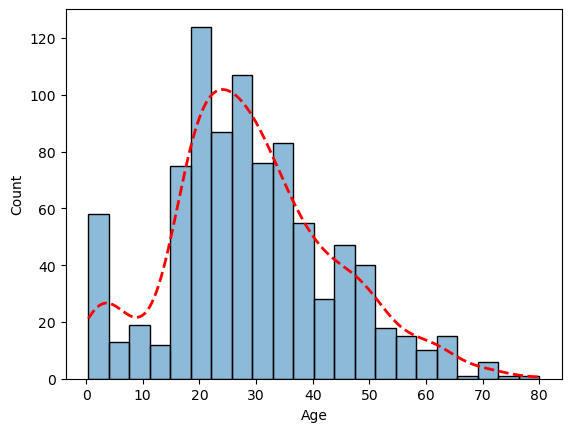

In [40]:
sns.histplot(x = train['Age'], kde = True, line_kws = {'linestyle' : 'dashed', 
                                                 'linewidth' : '2'}).lines[0].set_color('red')

Ahora continuamos con la variable "Sex"

In [41]:
#PassengerId
train.groupby(["Sex"])["Sex"].count().reset_index(name="Cantidad")

,Sex,Cantidad
0,female,314
1,male,577


La variable ticket, a primera vista no nos brinda información relevante, pero si observamos más detenidamente, se podrían encontrar varios patrones. Se podrían clasificar de la siguiente manera:
Tickets sin letra
Tickets que inician con alguna letra

Lo más probable es que estos registros tengan errores y se hayan llevado a cabo. Esta variable requiere un trabajo de limpieza y depuración. 
Primero que nada, observamos uqe hay tickets que de 4, 5 o 6 dígitos. No obstante, todos parecen tener continuidad en lo que respecta a los dos primeros dígitos. Por lo tanto, los tíckets sin letra se covertiran en tickets que consistan en los dos primeros dígitos.
Luego están los que inician con letra. Al parecer, los que inician con A, pueden ir seguidos de un 5 o un 4, por lo que estos tickets serán renombrados como A5 o A4 según corresponda. Luego están los que inician con C, CA, FC, 

Ahora vamos a iniciar con la magia de Python. Crearemos una pequeña función que detecte si hay espacios en una variable y que elimine la parte que precede a dicho espacio! 

In [42]:
def primer_caracter_despues_de_eliminar(texto):
    # Eliminar el contenido antes del primer espacio
    parte_despues_espacio = texto.split(' ', 1)[1] if ' ' in texto else texto
    # Retornar el primer carácter de esa parte
    return parte_despues_espacio[0] if parte_despues_espacio else ''


In [43]:
train['Ticket2'] = train['Ticket'].apply(primer_caracter_despues_de_eliminar)

In [44]:
train.groupby(["Ticket2"])["Ticket2"].count().reset_index(name="Cantidad")

,Ticket2,Cantidad
0,1,231
1,2,242
2,3,355
3,4,15
4,5,8
5,6,14
6,7,15
7,8,3
8,9,3
9,B,1


La variable ticket es de tipo string. Eliminamos la primera parte del string antes del espacio y nos quedamos con el primer dígito de la parte después del espacio. 

In [45]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket2
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3
5,6,0,3,"Moran, Mr. James",male,26.0,0,0,330877,8.4583,NaN,Q,3
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,3
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,2


In [46]:
train[train['Ticket2'].str.startswith(('L','B'))]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket2
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0000,NaN,S,L
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S,L
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0000,NaN,S,L
473,474,1,2,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",female,23.0,0,0,SC/AH Basle 541,13.7917,D,C,B
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0000,NaN,S,L


Vamos a intentar arreglar la variable ticket2 para que se pueda incluir en el modelo como de tipo numérica ordinal y no categórica.

In [47]:
train['Ticket2'] = train['Ticket2'].apply(lambda x: '1' if x.startswith(('B', 'L'))
                                   else x)

train.groupby(["Ticket2"])["Ticket2"].count().reset_index(name="Cantidad")
train["Ticket2"] = train["Ticket2"].astype(int)

Vamos a crear variables dummies

In [48]:
train = pd.get_dummies(train, columns = ['Sex', 'Pclass', 'Embarked'], drop_first=True, dtype=float)

In [49]:
train.head(3)

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Ticket2,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,2,1.0,0.0,1.0,0.0,1.0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0.0,0.0,0.0,0.0,0.0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,3,0.0,0.0,1.0,0.0,1.0


In [50]:
X_train = train[["Age", "SibSp", "Parch", "Fare", "Ticket2", "Sex_male", "Pclass_2", "Pclass_3", "Embarked_Q", "Embarked_S"]]
y_train = train[["Survived"]]

In [51]:
X_train.dtypes

Age           float64
SibSp           int64
Parch           int64
Fare          float64
Ticket2         int64
Sex_male      float64
Pclass_2      float64
Pclass_3      float64
Embarked_Q    float64
Embarked_S    float64
dtype: object

In [52]:
model = LogisticRegression()

In [53]:
model.fit(X_train, y_train)

/usr/lib/python3/dist-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Ahora vamos a usar nuestro modelo en el conjunto test

In [54]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


Usamos las funciones anteriormente creadas

In [55]:
test = hot_deck_imputation(test)
test['Ticket2'] = test['Ticket'].apply(primer_caracter_despues_de_eliminar)
test['Ticket2'] = test['Ticket2'].apply(lambda x: '1' if x.startswith(('B', 'L'))
                                   else x)

test.groupby(["Ticket2"])["Ticket2"].count().reset_index(name="Cantidad")
test["Ticket2"] = test["Ticket2"].astype(int)

test = pd.get_dummies(test, columns = ['Sex', 'Pclass', 'Embarked'], drop_first=True, dtype=float)

In [56]:
test.head(2)

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Ticket2,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,892,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,3,1.0,0.0,1.0,1.0,0.0
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,3,0.0,0.0,1.0,0.0,1.0


In [61]:
X_test = test[["Age", "SibSp", "Parch", "Fare", "Ticket2", "Sex_male", "Pclass_2", "Pclass_3", "Embarked_Q", "Embarked_S"]]

In [62]:
X_test.head(2)

,Age,SibSp,Parch,Fare,Ticket2,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,34.5,0,0,7.8292,3,1.0,0.0,1.0,1.0,0.0
1,47.0,1,0,7.0000,3,0.0,0.0,1.0,0.0,1.0


In [72]:
y_test = model.predict(X_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- const


In [73]:
#info del modelo

print("Intercept:", model.intercept_)
print("Coeficiente:", list(zip(X_test.columns, model.coef_.flatten(), )))
print("Accuracy de entrenamiento:", model.score(X, y))

Intercept: [3.48259543]
Coeficiente: [('const', -0.025993324622113373), ('Age', -0.32573249116847336), ('SibSp', -0.0808910116292583), ('Parch', 0.004733294447272842), ('Fare', -0.20898932791744038), ('Ticket2', -2.6825455070898023), ('Sex_male', -0.3430073566280586), ('Pclass_2', -1.3238539177747888), ('Pclass_3', 0.09360723675737384), ('Embarked_Q', -0.37004422602248316)]


NameError: name 'X' is not defined

In [75]:
# Agregar una constante al modelo
X_sm = sm.add_constant(X_test)

# Ajustar el modelo usando OLS (Ordinary Least Squares)
logit_model = sm.Logit(y_train, X_sm).fit()

# Mostrar el resumen del modelo
print(logit_model.summary())


MissingDataError: exog contains inf or nans

In [76]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.Logit(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.441226
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      880
Method:                           MLE   Df Model:                           10
Date:                Thu, 17 Oct 2024   Pseudo R-squ.:                  0.3374
Time:                        16:26:36   Log-Likelihood:                -393.13
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 7.776e-80
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8849      0.453      8.576      0.000       2.997       4.773
Age           -0.0289      0.

In [153]:
# Predicciones con intervalo de confianza 
# ==============================================================================
predicciones = modelo.predict(exog = X_train)

# Clasificación predicha
# ==============================================================================
clasificacion = np.where(predicciones<0.5, 0, 1)
clasificacion

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,

In [156]:
y_test = pd.DataFrame(clasificacion)

In [164]:
y_test.rename(columns={0: 'Survived'}, inplace=True)

In [ ]:
y_test

In [170]:
y_test = pd.concat([test["PassengerId"], y_test], axis=1)

In [172]:
y_test.dtypes

PassengerId    float64
Survived         int64
dtype: object

In [175]:
y_test["PassengerId"] = y_test["PassengerId"].astype(int)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [169]:
y_test.to_csv('resultados.csv', index=False)